In [29]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from scipy.ndimage import gaussian_filter
import pickle

In [30]:
data = pd.read_csv("exoplanet_data.csv").fillna(0)

forget i dont wanna refactor anything i just want to push the code and make a good looking readme file becuase right now I only have test dataset with me and not the train dataset. this dataset was obtained from kaggle. the data set name is NASA Exoplanet Dataset and the link is https://www.kaggle.com/datasets/arashnic/exoplanets

In [31]:
data["LABEL"].replace({1: 0, 2: 1}, inplace=True)

In [32]:
X = data.drop("LABEL", axis=1)
y = data["LABEL"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [34]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [35]:
X_train = gaussian_filter(X_train, sigma=10)
X_test = gaussian_filter(X_test, sigma=10)

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
pca_temp = PCA(random_state=42)
X_train_pca_temp = pca_temp.fit_transform(X_train)

explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)
k = np.argmax(explained_variance >= 0.90) + 1

k

np.int64(14)

In [38]:
pca = PCA(n_components=k, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

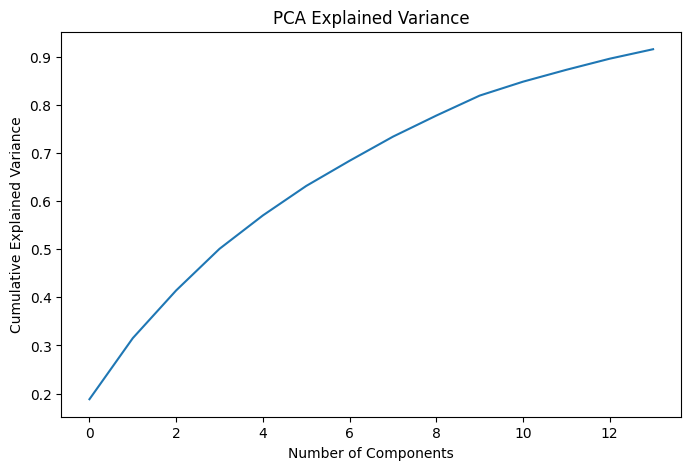

In [39]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [40]:
print("Class distribution in training data:")
print("Exoplanet (1):", sum(y_train == 1))
print("Non-Exoplanet (0):", sum(y_train == 0))

Class distribution in training data:
Exoplanet (1): 4
Non-Exoplanet (0): 452


In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, n_jobs=-1
    )

    print("Cross-validation Mean Accuracy:", cv_scores.mean())
    print("Cross-validation Std:", cv_scores.std())

    print("\nTest Accuracy:", accuracy_score(y_test, predictions))
    print("\nClassification Report:\n")
    print(classification_report(y_test, predictions))

    plt.figure(figsize=(6,5))
    sns.heatmap(
        confusion_matrix(y_test, predictions),
        annot=True,
        fmt="d",
        cmap="viridis"
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Cross-validation Mean Accuracy: 0.822001911132346
Cross-validation Std: 0.22387021451124345

Test Accuracy: 0.9912280701754386

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       113
           1       0.00      0.00      0.00         1

    accuracy                           0.99       114
   macro avg       0.50      0.50      0.50       114
weighted avg       0.98      0.99      0.99       114



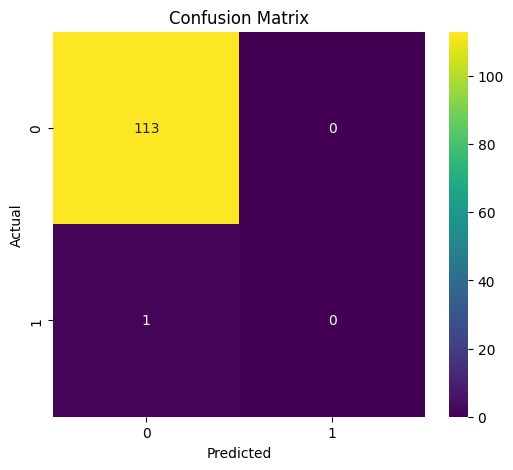

In [42]:
svm_model = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=True,
    random_state=42
)

evaluate_model(
    svm_model,
    X_train,
    y_train,
    X_test,
    y_test
)

Cross-validation Mean Accuracy: 0.9912326803631151
Cross-validation Std: 0.004383903910634938

Test Accuracy: 0.9912280701754386

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       113
           1       0.00      0.00      0.00         1

    accuracy                           0.99       114
   macro avg       0.50      0.50      0.50       114
weighted avg       0.98      0.99      0.99       114



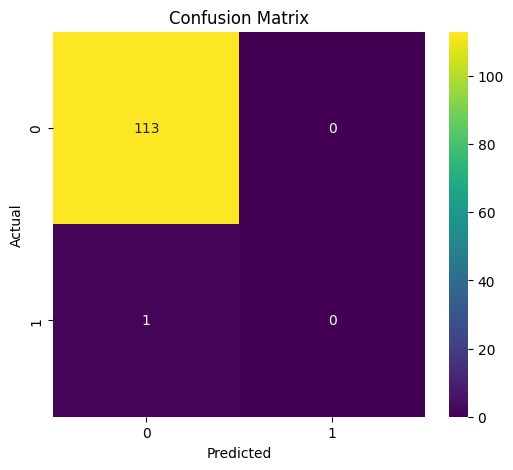

In [43]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

evaluate_model(
    rf_model,
    X_train,
    y_train,
    X_test,
    y_test
)

In [44]:
with open("exoplanet_rf_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)